## LoRAs of the World Unite - Training SOTA DreamBooth LoRA with Pivotal Tuning 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) using some of the most popular SOTA methods.

Learn more about the techniques used in this exmaple [here](linke to blogpost)

Let's get started 🧪

## Setup 🪓

In [1]:
# Install dependencies.
!pip install xformers bitsandbytes transformers accelerate wandb dadaptation prodigyopt -q

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
!pip install peft -q

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


Make sure to install `diffusers` from `main`.

In [1]:
!pip install git+https://github.com/huggingface/diffusers.git -q

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


Download diffusers SDXL DreamBooth training script.

In [2]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/advanced_diffusion_training/train_dreambooth_lora_sdxl_advanced.py

--2023-12-04 08:52:41--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/advanced_diffusion_training/train_dreambooth_lora_sdxl_advanced.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86471 (84K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl_advanced.py.1’

train_dreambooth_lo 100%[===================>]  84.44K  --.-KB/s    in 0.001s  

2023-12-04 08:52:41 (111 MB/s) - ‘train_dreambooth_lora_sdxl_advanced.py.1’ saved [86471/86471]



## Dataset 🐶

**Let's get our training data!**
For this example, we'll download some images from the hub.

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
pick option 1 or 2 below.

**Option 1:** upload example images from your local files:

In [ ]:
import os
from google.colab import files

# pick a name for the image folder
local_dir = "./my_folder" #@param
os.makedirs(local_dir)
os.chdir(local_dir)

# choose and upload local images into the newly created directory
uploaded_images = files.upload()
os.chdir("/content") # back to parent directory

**Option 2:** download example images from the hub - 

In [6]:
from huggingface_hub import snapshot_download

local_dir = "./3d_icon" #@param 
dataset_to_download = "LinoyTsaban/3d_icon" #@param
snapshot_download(
    dataset_to_download,
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

'/home/ubuntu/testing v2/3d_icon'

Preview the images:

In [7]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

/home/ubuntu/.local/lib/python3.10/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (132710400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


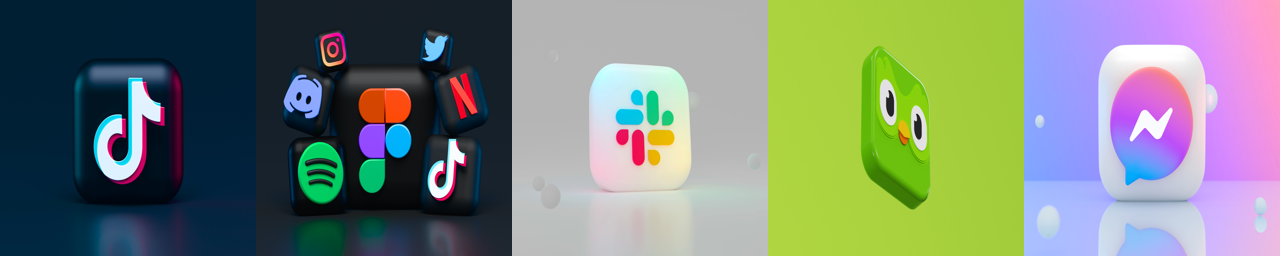

In [8]:
import glob
local_dir = "./3d_icon"
img_paths = f"{local_dir}/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with BLIP

Load BLIP2 to auto caption your images: 


**Note:** if you downloaded the `LinoyTsaban/3d_icon dataset` from the hub, you would find it already contains captions (generated with BLIP and prefixed with a token identifier) in the `metadata.jsonl` file
You can skip this part if you wish to train on that dataset using the existing captions. 

In [9]:
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
# load pipelines
blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",torch_dtype=torch.float16).to(device)

## IMAGE CPATIONING ##
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption


2023-11-26 18:54:29.686931: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 18:54:30.425056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./3d_icon/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

/home/ubuntu/.local/lib/python3.10/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (132710400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.

*Note:* When training with **pivotal tuning**, this token identifier (e.g. TOK) is only a **place holder**, and will be mapped to new tokens we insert to the tokenizers - so no need to spend too much time choosing the token!

Change the prefix according to the concept you're training on:
- for this example we can use "In the style of TOK," other options include:
    - For objects - "photoof a TOK/ a TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "In the style of TOK" we can use "3d icon in the style of TOK"/"a TOK 3d style icon"

saves image paths and corresponding prompts to metadata file for training 

In [12]:
import json
from IPython.display import display, Markdown

caption_prefix = "3d icon in the style of TOK, " #@param

# saves each caption and corresponding image to a metadata.jsonl file
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')
    
display(Markdown(f"Your image captions are ready here: {local_dir}metadata.jsonl"))

Your image captions are ready here: ./3d_icon/metadata.jsonl

Free some memory:

In [13]:
import gc

# delete the BLIP2 pipelines and clear up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [14]:
!accelerate config default

Configuration already exists at /home/ubuntu/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [3]:
from huggingface_hub import notebook_login
notebook_login()

## Train! 🔬

### `Diffusers` 🧨 Training loop

### hyperparameters 📐
1. **How to choose your hyperparams?** Check out this [blog post]() - where we explore and comapre different hyperparmas and configurations for different use cases, depending on your data and subject.     

2. **Make sure to add** `push_to_hub` so that the checkpoint is automatically pushed to the Hub and doesn't get lost. The `--push_to_hub` argument ensures that the trained checkpoints are automatically pushed to the Hugging Face Hub.

3. Some paramters that can help us with **compute** when doing DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL:

    * Gradient checkpointing (`--gradient_accumulation_steps`)
    * 8-bit Adam (`--use_8bit_adam`) - optional when using `--optimizer='AdamW'`, with `--optimizer='Prodigy'` this will be ignored
    * Mixed-precision training (`--mixed-precision="bf16"`)



### Launch training 🚀🚀🚀

**To allow for custom captions** we need to install the `datasets` library:
- Use `--caption_column` to specify name of the cpation column in your dataset. 
    - In this example we used `"prompt"` to
       save our captions in the metadata file, change this according to your needs.

**Otherwise:** 
- you can skip the installation if you want to train soley with `--instance_prompt`.
  in that case, specify `--instance_data_dir` instead of `--dataset_name`

In [16]:
# makes sure we install datasets from main
!pip install git+https://github.com/huggingface/datasets.git -q

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


#### 🤗Pick a name for your Dreambooth LoRA fine-tuned model:🤗
This name will be used to save your model, so pick an informative name based on your chosen concept💡

In [4]:
!pip install python-slugify
from slugify import slugify

model_name = "3d icon SDXL LoRA" # @param
output_dir = slugify(model_name)

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple/
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


**Instance & Validation Prompt**
* `instance_prompt` - 
    * when custom captions are enabled this prompt is still used in case there are missing captions, as well as in the model's readme. 
    * If custom captions are not used, this prompt will be used as the caption for all training images. 
* `validation_prompt` - 
    * this prompt is used to generate images throught the training process, this way you can see the models learning curve during training. 
    * you can also change `num_validation_images` (4 by default) and `validation_epochs` (50 by default) to control the amount images generated with the validation prompt, and the number of ephochs between each dreambooth validation.  

In [2]:
instance_prompt = "3d icon in the style of TOK" # @param
validation_prompt = "a TOK icon of an astronaut riding a horse, in the style of TOK" # @param

**Set your LoRA rank**
The rank of your LoRA is linked to its expressiveness.
The bigger the rank the closer we are to regular dreambooth, and in theory we have more expressive power (and heavier weights). 

For a very simple concept that you have a good high quality image set for (e.g. a pet, a generic object), a rank as low as 4 can be enough to get great results. We reccomend going between 8 and 64 depending on your concept and how much of a priortiy it is for you to keep the LoRA small or not.  

In [3]:
rank = 8 # @param

In [6]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl_advanced.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="./3d_icon" \
  --instance_prompt=$instance_prompt \
  --validation_prompt=$validation_prompt \
  --output_dir=$output_dir \
  --caption_column="prompt" \
  --mixed_precision="bf16" \
  --resolution=1024 \
  --train_batch_size=3 \
  --repeats=1\
  --report_to="wandb"\
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=1.0 \
  --text_encoder_lr=1.0 \
  --adam_beta2=0.99 \
  --optimizer="prodigy"\
  --train_text_encoder_ti\
  --train_text_encoder_ti_frac=0.5\
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --rank=$rank \
  --max_train_steps=1000 \
  --checkpointing_steps=2000 \
  --seed="0" \
  --push_to_hub

2023-12-04 08:53:29.479966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 08:53:30.305590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
12/04/2023 08:53:32 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: bf16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'dynamic_thresholding_ratio', 'variance_type', 'thresholding', 'clip_sample_range'} 

### Check out your model 🔥

In [7]:
from huggingface_hub import whoami
from pathlib import Path
from IPython.display import display, Markdown

username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

link_to_model = f"https://huggingface.co/{repo_id}"

display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/LinoyTsaban/3d-icon-sdxl-lora

## Inference 🐕

In [8]:
import torch
from huggingface_hub import hf_hub_download, upload_file
from diffusers import DiffusionPipeline
from diffusers.models import AutoencoderKL
from safetensors.torch import load_file

pipe = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        torch_dtype=torch.float16,
        variant="fp16",
).to("cuda")


pipe.load_lora_weights(repo_id, weight_name="pytorch_lora_weights.safetensors")


2023-12-04 09:37:49.371395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 09:37:50.221671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/46.6M [00:00<?, ?B/s]

#### Load Pivotal Tuning Embeddings

In [9]:
text_encoders = [pipe.text_encoder, pipe.text_encoder_2]
tokenizers = [pipe.tokenizer, pipe.tokenizer_2]

embedding_path = hf_hub_download(repo_id=repo_id, filename="embeddings.safetensors", repo_type="model")

state_dict = load_file(embedding_path)
# load embeddings of text_encoder 1 (CLIP ViT-L/14)
pipe.load_textual_inversion(state_dict["clip_l"], token=["<s0>", "<s1>"], text_encoder=pipe.text_encoder, tokenizer=pipe.tokenizer)
# load embeddings of text_encoder 2 (CLIP ViT-G/14)
pipe.load_textual_inversion(state_dict["clip_g"], token=["<s0>", "<s1>"], text_encoder=pipe.text_encoder_2, tokenizer=pipe.tokenizer_2)

embeddings.safetensors:   0%|          | 0.00/8.34k [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

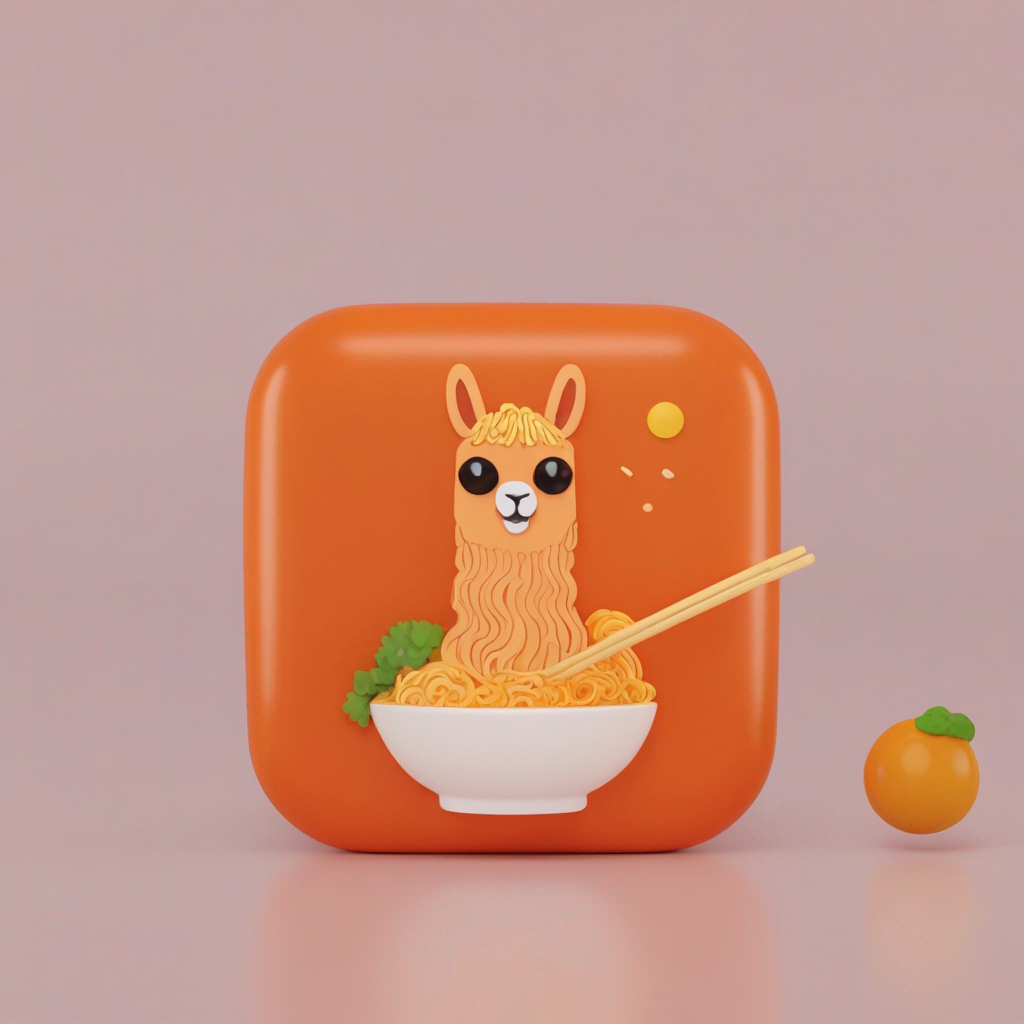

In [21]:
instance_token = "<s0><s1>"
prompt = f"a {instance_token} icon of an orange llama eating ramen, in the style of {instance_token}" 

image = pipe(prompt=prompt, num_inference_steps=25, cross_attention_kwargs={"scale": 1.0}).images[0]
image


